In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [9]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [10]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [11]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [12]:
df.isna().sum()

Money       0
Spending    0
dtype: int64

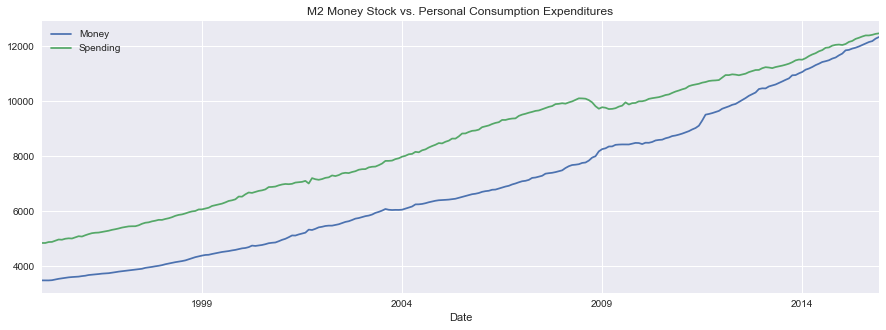

In [13]:
df.plot(figsize = (15,5), legend = True)
plt.title('M2 Money Stock vs. Personal Consumption Expenditures')
plt.show()

In [14]:
## test for stationary (augmented dickey-fuller test)
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [18]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [23]:
len(df_transformed)

250

In [24]:
# train and test split
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [25]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


In [26]:
# model building
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.151
,+ intercept,AIC,4606.303
Date:,"Thu, 23 Jul 2020",BIC,4665.331
Time:,16:37:29,HQIC,4630.092
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.82, 27.95",Jarque-Bera (JB):,"566.08, 127.11"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.69, 2.90",Skew:,"1.35, -0.35"


In [27]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-12.585986,38.015380
2015-02-01,-11.012522,-5.995164
2015-03-01,1.667994,0.098221
2015-04-01,-1.597160,-0.565184
2015-05-01,1.069720,0.338882
2015-06-01,-0.378108,-0.106255
2015-07-01,0.500006,0.172388
2015-08-01,-0.015102,0.010405
2015-09-01,0.290031,0.106617
2015-10-01,0.109801,0.049833


In [28]:
# invert the transform
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [29]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [30]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-12.585986,38.015380,66.014014,11657.514014,48.615380,12100.015380
2015-02-01,-11.012522,-5.995164,55.001492,11646.501492,42.620216,12094.020216
2015-03-01,1.667994,0.098221,56.669486,11648.169486,42.718437,12094.118437
2015-04-01,-1.597160,-0.565184,55.072326,11646.572326,42.153252,12093.553252
2015-05-01,1.069720,0.338882,56.142046,11647.642046,42.492135,12093.892135
2015-06-01,-0.378108,-0.106255,55.763938,11647.263938,42.385880,12093.785880
2015-07-01,0.500006,0.172388,56.263945,11647.763945,42.558268,12093.958268
2015-08-01,-0.015102,0.010405,56.248843,11647.748843,42.568673,12093.968673
2015-09-01,0.290031,0.106617,56.538874,11648.038874,42.675290,12094.075290
2015-10-01,0.109801,0.049833,56.648675,11648.148675,42.725123,12094.125123


In [31]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11657.514014,12100.015380
2015-02-01,11852.4,12082.4,11646.501492,12094.020216
2015-03-01,11868.8,12158.3,11648.169486,12094.118437
2015-04-01,11916.1,12193.8,11646.572326,12093.553252
2015-05-01,11947.6,12268.1,11647.642046,12093.892135
2015-06-01,11993.1,12308.3,11647.263938,12093.785880
2015-07-01,12045.3,12355.4,11647.763945,12093.958268
2015-08-01,12096.8,12394.0,11647.748843,12093.968673
2015-09-01,12153.8,12392.8,11648.038874,12094.075290


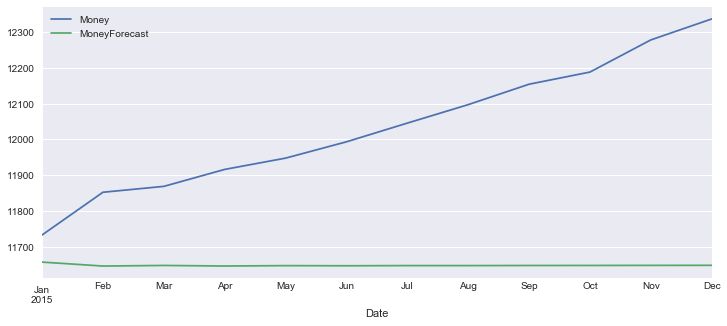

In [33]:
# plot the results
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True)
plt.show()

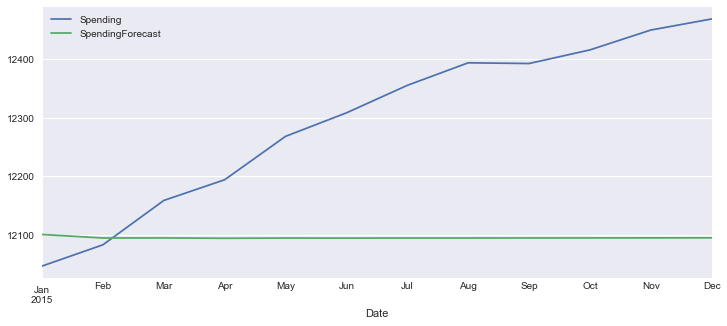

In [34]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True)
plt.show()

In [35]:
# model evaluation
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Money VAR(5) RMSE: 423.654
Spending VAR(5) RMSE: 243.587


### comparing results with ARMA model

In [36]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [37]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Thu, 23 Jul 2020   AIC                           2245.421
Time:                        16:41:27   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [38]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [39]:
z1

,Money
2015-01-01,-14.498789
2015-02-01,-10.946976
2015-03-01,4.152589
2015-04-01,-1.235735
2015-05-01,0.687104
2015-06-01,0.000933
2015-07-01,0.245795
2015-08-01,0.158416
2015-09-01,0.189597
2015-10-01,0.178470


In [40]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [41]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498789,64.101211,11734.201211
2015-02-01,-10.946976,53.154235,11787.355446
2015-03-01,4.152589,57.306824,11844.662269
2015-04-01,-1.235735,56.071089,11900.733358
2015-05-01,0.687104,56.758193,11957.491551
2015-06-01,0.000933,56.759126,12014.250677
2015-07-01,0.245795,57.004921,12071.255598
2015-08-01,0.158416,57.163337,12128.418935
2015-09-01,0.189597,57.352934,12185.771870
2015-10-01,0.178470,57.531405,12243.303275


In [42]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.654
Money  ARMA(1,2) RMSE: 32.237


In [43]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Thu, 23 Jul 2020   AIC                           2374.823
Time:                        16:42:48   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1438           +0.0000j            4.1438            0.5000
-----------------------------------------------------------------------------
"""

In [44]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555831
2015-02-01,-3.338264
2015-03-01,1.250702
2015-04-01,-0.310831
2015-05-01,0.220527
2015-06-01,0.039717
2015-07-01,0.101243
2015-08-01,0.080307
2015-09-01,0.087431
2015-10-01,0.085007


In [45]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [46]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555831,44.155831,12106.155831
2015-02-01,-3.338264,40.817567,12146.973398
2015-03-01,1.250702,42.068269,12189.041666
2015-04-01,-0.310831,41.757438,12230.799104
2015-05-01,0.220527,41.977965,12272.777069
2015-06-01,0.039717,42.017681,12314.794750
2015-07-01,0.101243,42.118924,12356.913674
2015-08-01,0.080307,42.199231,12399.112905
2015-09-01,0.087431,42.286662,12441.399566
2015-10-01,0.085007,42.371668,12483.771234


In [47]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 243.587
Spending  ARMA(1,2) RMSE: 52.334


- CONCLUSION: It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures.